In [1]:
import pandas as pd
import numpy as np 

from discopy import Id, Ty

from discopro.grammar import tensor
from discopro.rewriting import contract, pronoun_rule
from discopro.anaphora import connect_anaphora_on_top
import discopro.training as train

from lambeq.ccg2discocat import DepCCGParser
from lambeq.circuit import IQPAnsatz
from lambeq.core.types import AtomicType
from lambeq.rewrite import Rewriter

from pytket.extensions.qulacs import QulacsBackend
from pytket.extensions.qiskit import AerBackend

from multiprocessing import Pool, cpu_count
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITION

SEED = 0

In [2]:
parser = DepCCGParser()
def parse(sent):
    sentences = map(str.strip, sent.split('.'))
    diag = Id(Ty())
    for s in sentences:
        if len(s) == 0:
            continue
        diag = tensor(diag, parser.sentence2diagram(s))
    return diag

In [3]:
rewrite = Rewriter(['auxiliary', 'determiner', 'prepositional_phrase', 'connector', 'postadverb', 'preadverb'])
rewrite.add_rules(pronoun_rule)

ansatz = IQPAnsatz({N: 1, S: 1, P: 1}, n_layers=1)

In [4]:
csv_path = "datasets/wino2/{:}.csv"
df_train = pd.read_csv(csv_path.format('train')).head(5)
df_dev = pd.read_csv(csv_path.format('dev'))
df_test = pd.read_csv(csv_path.format('test'))

In [5]:
df_train['label_one_hot'] = df_train['label'].map({0: [1, 0], 1: [0, 1]})
df_dev['label_one_hot'] = df_dev['label'].map({0: [1, 0], 1: [0, 1]})
df_test['label_one_hot'] = df_test['label'].map({0:[1, 0], 1: [0, 1]})

In [9]:
def sent_to_diag(row):
    sent, pro, ref = row
    diag = parse(sent)
    pro_box_idx = next(i for i, box in enumerate(diag.boxes) if box.name.casefold() == pro.casefold())
    ref_box_idx = next(i for i, box in enumerate(diag.boxes) if box.name.casefold() == ref.casefold())
    diag = connect_anaphora_on_top(diag, pro_box_idx, ref_box_idx)
    diag = rewrite(diag).normal_form()
    diag = contract(diag)
    return diag 

df_train['diagram'] = df_train[['sentence', 'pronoun', 'referent']].apply(sent_to_diag, axis=1)
df_dev['diagram'] = df_dev[['sentence', 'pronoun', 'referent']].apply(sent_to_diag, axis=1)
df_test['diagram'] = df_test[['sentence', 'pronoun', 'referent']].apply(sent_to_diag, axis=1)

df_train['circuit'] = df_train['diagram'].map(ansatz)
df_dev['circuit'] = df_dev['diagram'].map(ansatz)
df_test['circuit'] = df_test['diagram'].map(ansatz)

In [42]:
all_circuits = pd.concat([df_train['circuit'], df_dev['circuit'], df_test['circuit']])
circ_symbols = train.get_sorted_symbols(all_circuits)
reduction_tensor, tensor_symbols = train.get_reduction_tensor('R', 2)
symbols = circ_symbols + tensor_symbols

post_process = train.make_default_post_process(reduction_tensor, symbols)
backend = QulacsBackend()
optim_level = 2
pool = Pool(cpu_count())
eval_config = {'n_shots': 2**6,
               'seed': SEED,
               'parallel_eval': True,
               'backend_name': 'qulacs',
               'backend': backend,
               'compilation_optim_level': optim_level,
               'compilation': backend.default_compilation_pass(optim_level),
               'pool': pool}

pred_fn_train = train.make_pred_fn(df_train['circuit'], symbols, post_process, **eval_config)
pred_fn_dev = train.make_pred_fn(df_dev['circuit'], symbols, post_process, **eval_config)
pred_fn_test = train.make_pred_fn(df_test['circuit'], symbols, post_process, **eval_config)

cost_fn_train, costs_train, accs_train = train.make_cost_fn(pred_fn_train, df_train['label_one_hot'].to_list())
cost_fn_dev, costs_dev, accs_dev = train.make_cost_fn(pred_fn_dev, df_dev['label_one_hot'].to_list())

In [43]:
rng = np.random.default_rng(SEED)
x0 = rng.random(len(symbols))
niter = 5
a = 0.2
c = 0.06
x, history = train.minimizeSPSA(cost_fn_train, x0=x0, a=a, c=c, niter=niter, rng=rng, callback=cost_fn_dev)
x_hist, func_plus_hist, func_minus_hist, grad_hist = history

  0%|          | 0/5 [00:00<?, ?it/s]

ValueError: Pool not running

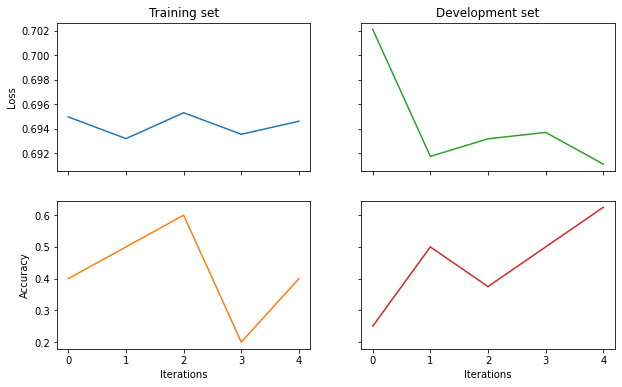

In [45]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(func_plus_hist, color=next(colours))  # training evaluates twice per iteration
ax_bl.plot(accs_train[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(costs_dev, color=next(colours))
ax_br.plot(accs_dev, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = train.make_cost_fn(pred_fn_test, df_test['label_one_hot'].to_list())
test_cost_fn(x)
print('Test accuracy:', test_accs[0])

pool.close()
pool.join()